In [18]:
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'
import json
from collections import Counter

def normal_imp(mydict):
    mysum = sum(mydict.values())  
    for key in mydict: 
        mydict[key] = mydict[key] / mysum 
    return mydict

def get_nb_f(mydf):
    p_lst = mydf.p_delong.tolist()
    i = 0
    while i < len(p_lst) - 1 and ((p_lst[i] < 0.05) or (p_lst[i+1] < 0.05)):
        i += 1
    return i

file_path = "/Volumes/data_files/UKB_data/immune_result/lgb_results_4_importance/SLE_feature_importance.json"
data = pd.read_json(file_path)
totalgain = data['totalgain']
totalcover = data['totalcover']
df_totalgain_raw = pd.DataFrame(list(totalgain.items()), columns=['Pro_code', 'TotalGain_cv'])

mydict = dict(zip(df_totalgain_raw['Pro_code'], df_totalgain_raw['TotalGain_cv']))

tg_imp_cv = Counter()
tg_imp_cv += Counter(normal_imp(mydict))
tg_imp_cv = normal_imp(tg_imp_cv)
df_totalgain= pd.DataFrame(list(tg_imp_cv.items()), columns=['Pro_code', 'TotalGain_cv'])
df_totalcover = pd.DataFrame(list(totalcover.items()), columns=['Pro_code', 'TotalCover_cv'])
pro_imp_df = pd.merge(df_totalgain, df_totalcover, on='Pro_code')
pro_imp_df.rename(columns = {'TotalGain_cv': 'Pro_imp'}, inplace = True)
pro_auc_df = pd.read_csv("/Volumes/data_files/UKB_data/immune_result/SLE_AUC_sorted.csv")
pro_auc_df.columns = ['Pro_list', 'AUC_mean', 'AUC_std', 'p_delong', 'AUC_0', 'AUC_1', 'AUC_2', 'AUC_3', 'AUC_4', 'AUC_5', 'AUC_6', 'AUC_7', 'AUC_8', 'AUC_9']
totalgain_code = df_totalgain.sort_values(by = 'TotalGain_cv', ascending = False)['Pro_code'].tolist()
df_totalgain_code = pd.DataFrame(totalgain_code, columns = ['Pro_code'])
pro_auc_df['Pro_code'] = df_totalgain_code


In [19]:
pro_auc_df["Pro_list"] = pro_auc_df["Pro_list"].str.upper()
# pro_auc_df["Pro_code"] = pro_auc_df["Pro_code"].str.upper()
pro_auc_df

,Pro_list,AUC_mean,AUC_std,p_delong,AUC_0,AUC_1,AUC_2,AUC_3,AUC_4,AUC_5,AUC_6,AUC_7,AUC_8,AUC_9,Pro_code
0,['TRIM21'],0.610,0.023,4.438435e-01,0.607,0.608,0.590,0.567,0.602,0.624,0.623,0.611,0.660,0.613,trim21
1,"['TRIM21', 'IL15']",0.717,0.030,4.458281e-06,0.731,0.682,0.711,0.702,0.726,0.687,0.680,0.781,0.747,0.722,il15
2,"['TRIM21', 'IL15', 'SCARB2']",0.758,0.026,2.009521e-06,0.765,0.708,0.773,0.728,0.768,0.737,0.764,0.799,0.753,0.786,scarb2
3,"['TRIM21', 'IL15', 'SCARB2', 'LGALS9']",0.807,0.021,1.511778e-09,0.813,0.751,0.822,0.811,0.820,0.814,0.793,0.803,0.822,0.820,lgals9
4,"['TRIM21', 'IL15', 'SCARB2', 'LGALS9', 'PDCD1']",0.827,0.019,2.260756e-09,0.824,0.785,0.856,0.829,0.835,0.824,0.817,0.821,0.830,0.854,pdcd1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,"['TRIM21', 'IL15', 'SCARB2', 'LGALS9', 'PDCD1'...",0.884,0.018,3.960415e-21,0.895,0.852,0.920,0.873,0.892,0.898,0.877,0.878,0.874,0.876,NaN
468,"['TRIM21', 'IL15', 'SCARB2', 'LGALS9', 'PDCD1'...",0.878,0.022,7.486868e-17,0.876,0.833,0.925,0.868,0.883,0.893,0.879,0.866,0.869,0.889,NaN
469,"['TRIM21', 'IL15', 'SCARB2', 'LGALS9', 'PDCD1'...",0.879,0.019,8.163238e-18,0.887,0.840,0.908,0.866,0.886,0.897,0.862,0.864,0.886,0.891,NaN
470,"['TRIM21', 'IL15', 'SCARB2', 'LGALS9', 'PDCD1'...",0.878,0.019,2.075227e-14,0.864,0.845,0.908,0.866,0.880,0.901,0.876,0.856,0.894,0.889,NaN


In [20]:
mydf = pd.merge(pro_auc_df, pro_imp_df, how = 'left', on = ['Pro_code'])
mydf['AUC_lower'] = mydf['AUC_mean'] - 1.96*mydf['AUC_std']
mydf['AUC_upper'] = mydf['AUC_mean'] + 1.96*mydf['AUC_std']
mydf['pro_idx'] = [i for i in range(1, len(mydf)+1)]
nb_f = get_nb_f(mydf)
mydf

,Pro_list,AUC_mean,AUC_std,p_delong,AUC_0,AUC_1,AUC_2,AUC_3,AUC_4,AUC_5,AUC_6,AUC_7,AUC_8,AUC_9,Pro_code,Pro_imp,TotalCover_cv,AUC_lower,AUC_upper,pro_idx
0,['TRIM21'],0.610,0.023,4.438435e-01,0.607,0.608,0.590,0.567,0.602,0.624,0.623,0.611,0.660,0.613,trim21,0.037899,38.0,0.56492,0.65508,1
1,"['TRIM21', 'IL15']",0.717,0.030,4.458281e-06,0.731,0.682,0.711,0.702,0.726,0.687,0.680,0.781,0.747,0.722,il15,0.037329,44.0,0.65820,0.77580,2
2,"['TRIM21', 'IL15', 'SCARB2']",0.758,0.026,2.009521e-06,0.765,0.708,0.773,0.728,0.768,0.737,0.764,0.799,0.753,0.786,scarb2,0.022510,65.0,0.70704,0.80896,3
3,"['TRIM21', 'IL15', 'SCARB2', 'LGALS9']",0.807,0.021,1.511778e-09,0.813,0.751,0.822,0.811,0.820,0.814,0.793,0.803,0.822,0.820,lgals9,0.020596,23.0,0.76584,0.84816,4
4,"['TRIM21', 'IL15', 'SCARB2', 'LGALS9', 'PDCD1']",0.827,0.019,2.260756e-09,0.824,0.785,0.856,0.829,0.835,0.824,0.817,0.821,0.830,0.854,pdcd1,0.018162,22.0,0.78976,0.86424,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,"['TRIM21', 'IL15', 'SCARB2', 'LGALS9', 'PDCD1'...",0.884,0.018,3.960415e-21,0.895,0.852,0.920,0.873,0.892,0.898,0.877,0.878,0.874,0.876,NaN,NaN,NaN,0.84872,0.91928,468
468,"['TRIM21', 'IL15', 'SCARB2', 'LGALS9', 'PDCD1'...",0.878,0.022,7.486868e-17,0.876,0.833,0.925,0.868,0.883,0.893,0.879,0.866,0.869,0.889,NaN,NaN,NaN,0.83488,0.92112,469
469,"['TRIM21', 'IL15', 'SCARB2', 'LGALS9', 'PDCD1'...",0.879,0.019,8.163238e-18,0.887,0.840,0.908,0.866,0.886,0.897,0.862,0.864,0.886,0.891,NaN,NaN,NaN,0.84176,0.91624,470
470,"['TRIM21', 'IL15', 'SCARB2', 'LGALS9', 'PDCD1'...",0.878,0.019,2.075227e-14,0.864,0.845,0.908,0.866,0.880,0.901,0.876,0.856,0.894,0.889,NaN,NaN,NaN,0.84076,0.91524,471


In [21]:
import pickle
import joblib
file_path = "/Volumes/data_files/UKB_data/immune_result/lgb_results_4_importance/SLE_shap_values.pkl"
nb_f = 11
shap_values = joblib.load(file_path)
shap_values

array([[-7.58256545e-03, -4.14545989e-03,  0.00000000e+00, ...,
        -3.74093555e-04,  1.05469642e-03,  1.74814065e-03],
       [ 2.70511843e-03, -1.61034891e-03,  0.00000000e+00, ...,
         6.75998699e-04,  1.24431187e-03, -2.03489751e-03],
       [ 2.43196861e-03, -8.09315351e-04,  0.00000000e+00, ...,
         6.52758675e-04,  1.85765329e-03,  2.38223665e-04],
       ...,
       [-1.02069111e-02,  1.87091156e-03,  0.00000000e+00, ...,
        -7.34389115e-05,  7.74939517e-04, -1.61012101e-03],
       [ 1.79091528e-03,  7.60606649e-05,  0.00000000e+00, ...,
        -9.86047790e-05, -7.48146680e-04,  3.89938075e-03],
       [ 4.45689158e-04,  9.86739907e-04,  0.00000000e+00, ...,
        -9.97459026e-05,  5.31763501e-03,  1.48181657e-03]])

/var/folders/sy/n_c36kvx487143mhq4gvc7b40000gn/T/ipykernel_57568/4057788406.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x="Pro_code", y="Pro_imp", palette=palette, data=top_40_mydf)
/var/folders/sy/n_c36kvx487143mhq4gvc7b40000gn/T/ipykernel_57568/4057788406.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_40_mydf['Pro_code'], rotation=45, fontsize=16, horizontalalignment='right')


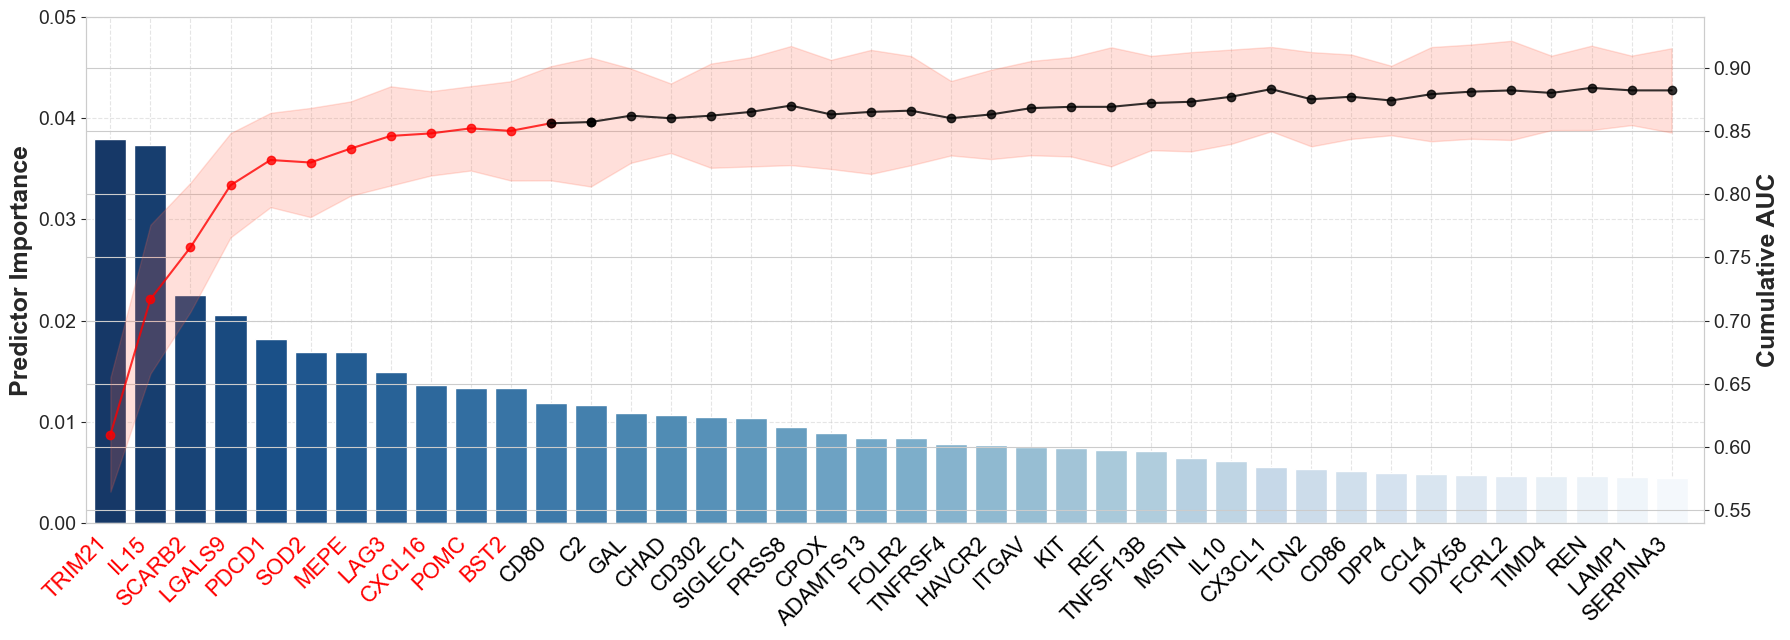

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


top_40_mydf = mydf.sort_values(by="Pro_imp", ascending=False).iloc[:40]
# 确保 `Pro_code` 变为大写
top_40_mydf["Pro_code"] = top_40_mydf["Pro_code"].str.upper()

fig, ax = plt.subplots(figsize=(18, 6.5))

palette = sns.color_palette("Blues", n_colors=len(top_40_mydf))
palette.reverse()

# 画 barplot
sns.barplot(ax=ax, x="Pro_code", y="Pro_imp", palette=palette, data=top_40_mydf)

# 设置 y 轴限制
y_imp_up_lim = round(top_40_mydf['Pro_imp'].max() + 0.01, 2)
ax.set_ylim([0, y_imp_up_lim])

# 设置刻度和字体大小
ax.tick_params(axis='y', labelsize=14)
ax.set_xticklabels(top_40_mydf['Pro_code'], rotation=45, fontsize=16, horizontalalignment='right')

# 颜色标记
my_col = ['r'] * nb_f + ['k'] * (len(top_40_mydf) - nb_f)
for ticklabel, tickcolor in zip(ax.get_xticklabels(), my_col):
    ticklabel.set_color(tickcolor)

ax.set_ylabel('Predictor Importance', weight='bold', fontsize=18)
ax.set_xlabel('')

ax.grid(which='minor', alpha=0.2, linestyle=':')
ax.grid(which='major', alpha=0.5, linestyle='--')
ax.set_axisbelow(True)

# 添加次坐标轴（AUC 曲线）
ax2 = ax.twinx()
ax2.plot(np.arange(nb_f + 1), top_40_mydf['AUC_mean'][:nb_f + 1], 'red', alpha=0.8, marker='o')
ax2.plot(np.arange(nb_f + 1, len(top_40_mydf)), top_40_mydf['AUC_mean'][nb_f + 1:], 'black', alpha=0.8, marker='o')
ax2.plot([nb_f, nb_f + 1], top_40_mydf['AUC_mean'][nb_f:nb_f + 2], 'black', alpha=0.8, marker='o')

# 置信区间填充
plt.fill_between(top_40_mydf.index, top_40_mydf['AUC_lower'], top_40_mydf['AUC_upper'], color='tomato', alpha=0.2)

ax2.set_ylabel('Cumulative AUC', weight='bold', fontsize=18)
ax2.tick_params(axis='y', labelsize=14)

# 设置 y 轴范围
y_auc_up_lim = round(top_40_mydf['AUC_upper'].max() + 0.02, 2)
y_auc_low_lim = round(top_40_mydf['AUC_lower'].min() - 0.02, 2)
ax2.set_ylim([y_auc_low_lim, y_auc_up_lim])

fig.tight_layout()

plt.xlim([-.6, len(top_40_mydf) - .2])

# 保存 PDF
plt.savefig('SLE_Predictor_Importance.pdf', format='pdf')